In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12497195103801211432
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14357954560
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5239748719894203517
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

import os
import pandas as pd
import zipfile

# Path to your ZIP file and the output CSV
zip_path = '/content/drive/MyDrive/Capstone/Project.zip'


# Extract ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('Project')

# Walk through the extracted folders and create the CSV data
data = []
root_path = 'Project'
for dirpath, dirnames, filenames in os.walk(root_path):
    for file in filenames:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            label = os.path.basename(dirpath)
            image_path = os.path.join(dirpath, file)
            data.append([image_path, label])

# Convert to DataFrame and save as CSV
df = pd.DataFrame(data, columns=['Image_path', 'Label'])


In [5]:
df

,Image_path,Label
0,Project/Project/Arborio/Arborio (11448).jpg,Arborio
1,Project/Project/Arborio/Arborio (13187).jpg,Arborio
2,Project/Project/Arborio/Arborio (624).jpg,Arborio
3,Project/Project/Arborio/Arborio (464).jpg,Arborio
4,Project/Project/Arborio/Arborio (14933).jpg,Arborio
...,...,...
74995,Project/Project/Basmati/basmati (10496).jpg,Basmati
74996,Project/Project/Basmati/basmati (8148).jpg,Basmati
74997,Project/Project/Basmati/basmati (11778).jpg,Basmati
74998,Project/Project/Basmati/basmati (1054).jpg,Basmati


In [6]:
import plotly.express as px

# Prepare the data for Plotly Express
df_counts = df['Label'].value_counts().reset_index()
df_counts.columns = ['Rice', 'Counts']

# Using a categorical color scale for the plants
fig = px.bar(df_counts,
             x='Rice',
             y='Counts',
             title='Value Counts for each type of rice',
             labels={'Type of Rice': 'Rice', 'Counts': 'Counts'},
             color='Rice',
             category_orders={"Rice": df_counts['Rice'].tolist()})

# Update the color scale
fig.update_traces(marker=dict(line=dict(width=0.5, color='DarkSlateGrey')))

# Show the plot
fig.show()

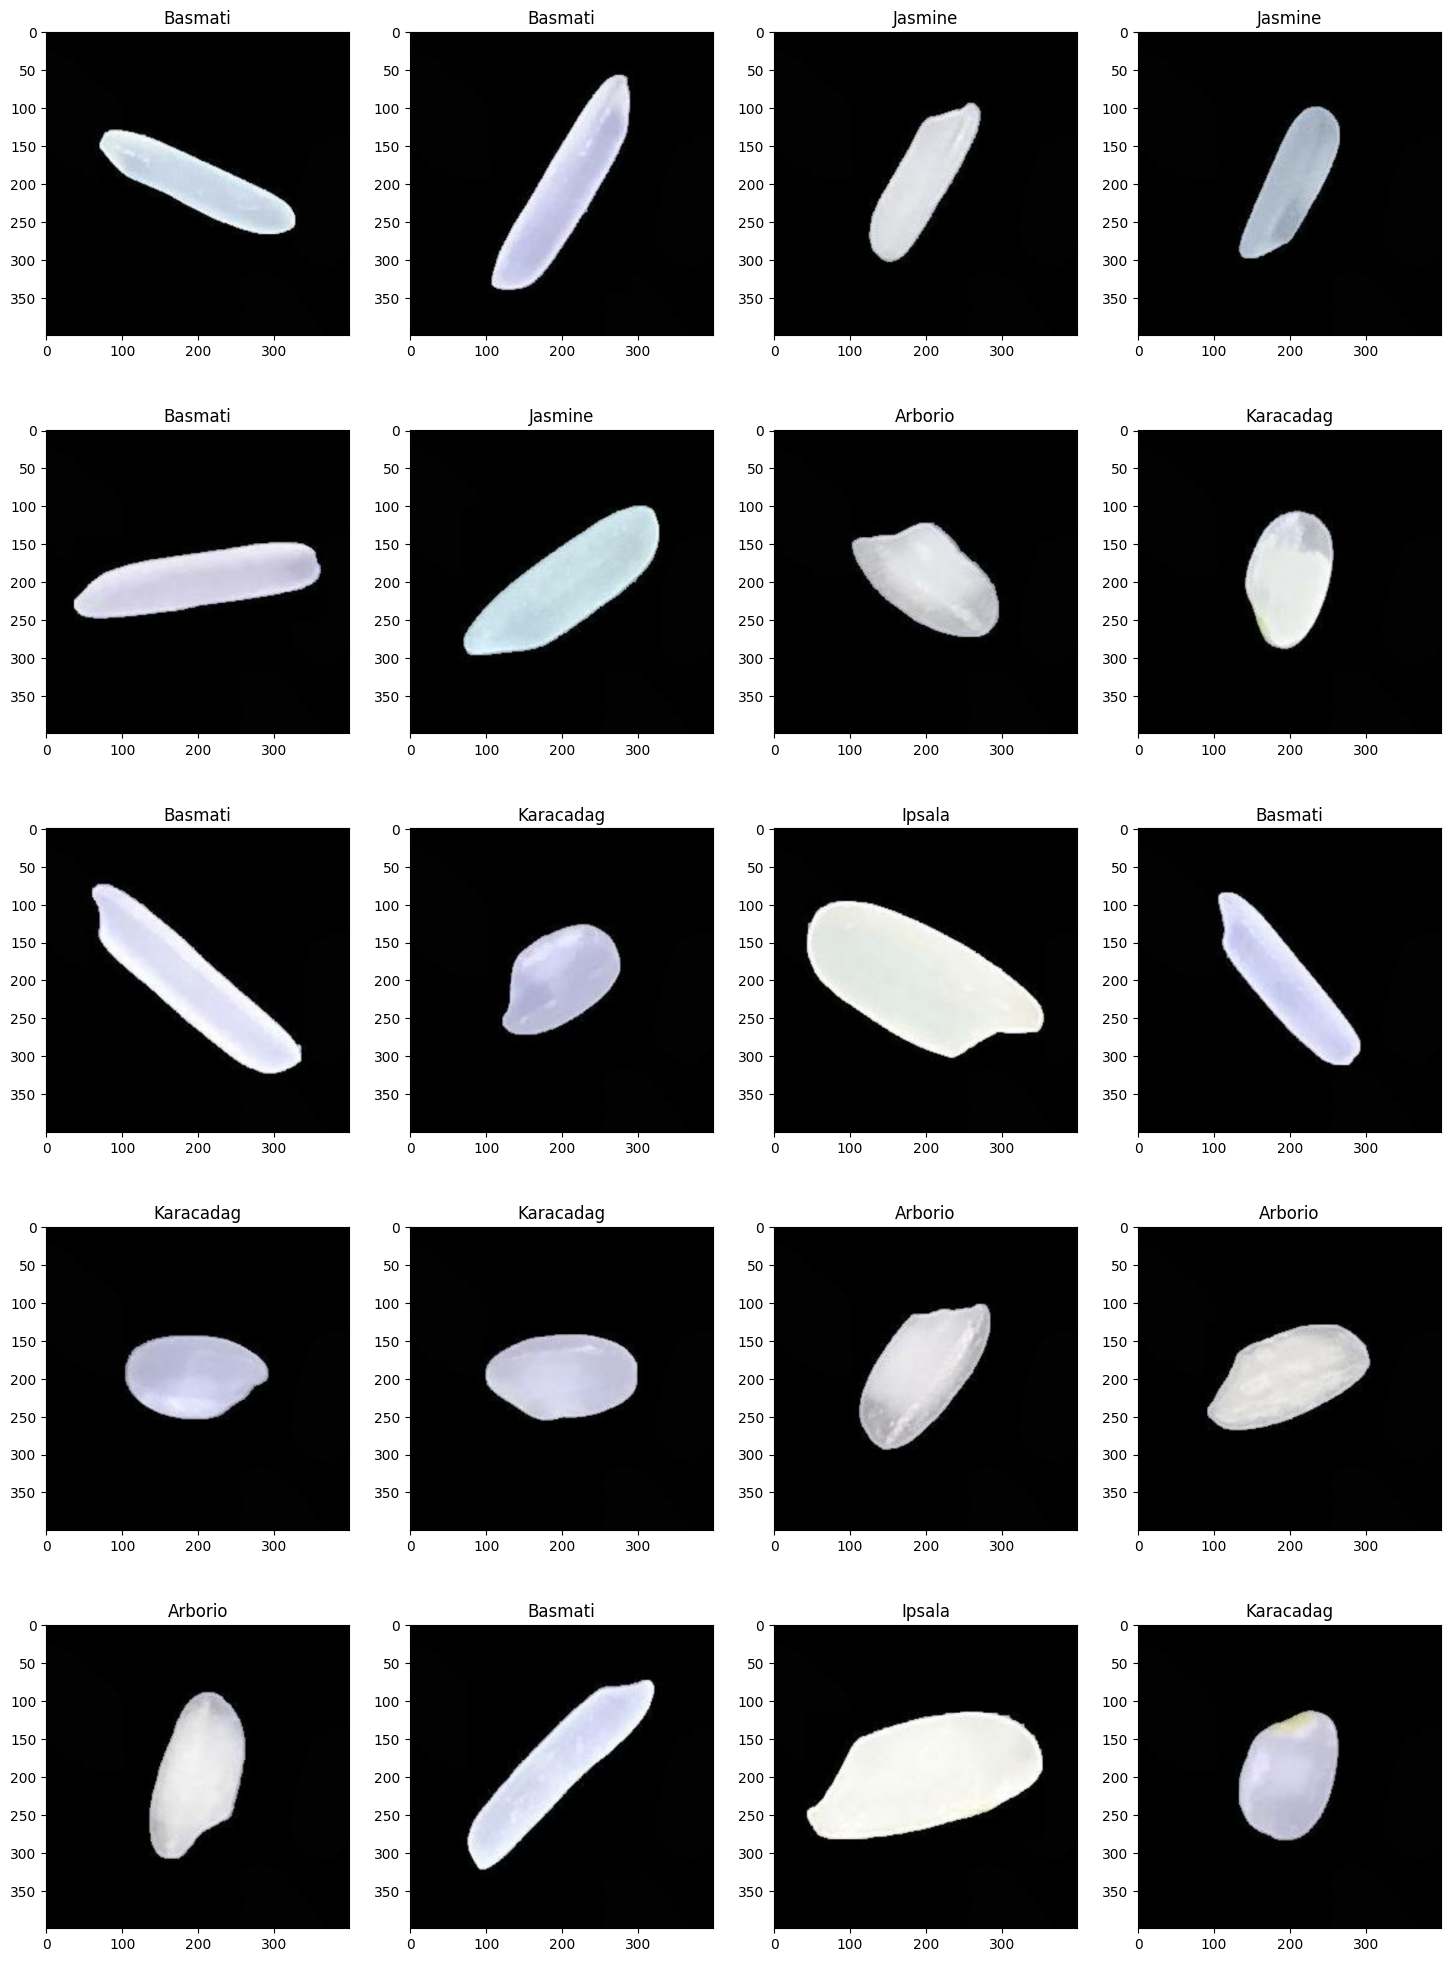

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(18,25))

# Randomly sample 20 rows from the dataframe
random_samples = df.sample(20)

for i, (index, row) in enumerate(random_samples.iterrows()):
    plt.subplot(5, 4, i + 1)

    image = tf.io.read_file(row['Image_path'])
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [400, 400])

    plt.imshow(image)
    plt.title(row['Label'])

plt.show()

#TRAIN TEST SPLIT

In [8]:
from sklearn.model_selection import train_test_split
Train, Test = train_test_split(df,test_size=0.3, stratify = df['Label'],random_state=100)

#ENCODING TARGET LABELS

In [9]:
Train_image_labels, unique_labels = pd.factorize(Train['Label'])
Test_image_labels = pd.Series(Test['Label']).map({label: i for i, label in enumerate(unique_labels)}).values


In [10]:
Train_image_paths = Train['Image_path'].values.tolist()
Test_image_paths = Test['Image_path'].values.tolist()


In [11]:


import tensorflow as tf
import numpy as np

def parse_function(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image / 255.0
    image = tf.image.resize(image, [400, 400])
    y = tf.one_hot(tf.cast(label, tf.uint8), 120)
    return image, y

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))  # maxval should be 4
    image = tf.image.random_hue(image, 0.08)  # Reduced for a more realistic augmentation
    image = tf.image.random_saturation(image, 0.6, 1.5)
    image = tf.image.random_brightness(image, 0.05)  # Reduced for a more realistic augmentation
    image = tf.image.random_contrast(image, 0.7, 1.3)
    return image, label

def tfdata_generator(images, labels, is_training, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    dataset = dataset.map(parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_training:
        dataset = dataset.shuffle(18000)
        dataset = dataset.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    dataset = dataset.batch(batch_size, drop_remainder=True if is_training else False)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset


In [12]:
batch_size = 16

In [13]:
from tensorflow.python import test
train_generator       = tfdata_generator(Train_image_paths, Train_image_labels, is_training=True)
test_generator  = tfdata_generator(Test_image_paths, Test_image_labels, is_training=False)

In [14]:
import math

steps_per_epoch = math.ceil(len(Train_image_paths) / batch_size)
validation_steps = math.ceil(len(Test_image_paths) / batch_size)


In [15]:
from tensorflow import keras
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet import ResNet152
from keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten,GlobalAveragePooling2D,Concatenate,BatchNormalization
from keras.models import Model
from keras.utils import plot_model
import os
import random as rn

In [16]:
os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [17]:
keras.backend.clear_session()
np.random.seed(0)
rn.seed(0)

In [18]:
from tensorflow.keras import layers, Model, optimizers, Sequential
from tensorflow.keras.applications import InceptionV3



input_shape = (400, 400, 3)
input_layer = layers.Input(shape=input_shape)

# First model
base_inception = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_layer)

# Set layers of base_inception to non-trainable
for layer in base_inception.layers:
    layer.trainable = False

# Linear stack of layers using Sequential API
model = Sequential([
    base_inception,
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(250, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(120, activation='softmax')
], name="Inception")

model.compile(optimizer=optimizers.SGD(lr=0.001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

model.summary()


87910968/87910968 [==============================] - 5s 0us/step


Model: "Inception"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 11, 11, 2048)      21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense (Dense)               (None, 250)               512250    
                                                                 
 dropout (Dropout)           (None, 250)               0 

In [ ]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

# Set up the directory to save the model weights
model_save_dir = '/content/drive/MyDrive/Capstone/'
os.makedirs(model_save_dir, exist_ok=True)

# Callbacks
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
mc = ModelCheckpoint(os.path.join(model_save_dir, 'Inception_best_weights.h5'),
                     monitor='val_loss', mode='min', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=2, verbose=1)
tb = TensorBoard(log_dir=os.path.join(model_save_dir, 'logs'), histogram_freq=1)

# Fitting the model
model.fit(train_generator,
              steps_per_epoch=steps_per_epoch,
              validation_data=test_generator,
              epochs=25,
              validation_steps=validation_steps,
              callbacks=[mc, reduce_lr, es, tb])  # Added TensorBoard to callbacks


Epoch 1/25
